In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import h5py
%matplotlib notebook

# Checking is the times output is the same as the scale to years output we get from the analysis above

In [70]:
df_times = pd.read_csv("/Users/eniaxhakaj/Github/consistent-trees/times_array_output_2.txt")


scale_factor_ct = df_times["scale_factor"]
times_ct = df_times[" time"]

sf_set = np.unique(scale_factor_ct)

# print sf_set
# print "what are you doing???"
# print scale_factor_ct[:10]
# list(df_sorted)

# plot scale factor vs time 
times_set = []
same_sf = []
same_t = []

for sf in sf_set: 

    # where is this sf in the scale factor full array we got from the perl code
    idx_sf = np.where(scale_factor_ct == sf)[0]
    
    # which are the times for that array?
    same_t = times_ct[idx_sf]
    
    # Use the median as your represeantitve
    times_set.append(np.mean(same_t))
    
print len(times_set)

192


In [71]:
STEPS = 1024 
omega_0 = 0.3 #// Matter density
t_0 = 0       # // Time now (in Hubble time units).
times = np.zeros(STEPS+1)
H_CONV = 9.77813952e9/0.7
exact_t0_conv = 0



def init_time_table(Om, h0):
    
    a = 1
    omega_0 = Om
    H_CONV = 9.77813952e9/h0 # // 1/(1 km/s/Mpc) in years

    times[STEPS] = t_0
    exact_t0_conv = exact_scale_to_time(1.0)
    
    for i in range(1, STEPS):
        a = 1.0-i/float(STEPS)
        times[STEPS-i] = exact_scale_to_time(a)
    
    return 



def _exact_time_to_scale(t):
    
    m = np.sinh(1.5*t*np.sqrt(1.0-omega_0))
    
    return np.power(omega_0*m*m/(1.0-omega_0), 1.0/3.0)


def exact_scale_to_time(scale):
    
    t = scale
    a = _exact_time_to_scale(t)
    dt = scale/10.0
    count = 0
    
    while (abs(a-scale)>1e-7 and (count < 10)):
        count += 1
        a2 = _exact_time_to_scale(t+dt)
        move = (scale-a)*(dt)/(a2-a)
        t += move
        a = _exact_time_to_scale(t)

        if move/10.0 < 0.5*dt:
            dt = move/10.0
        else:
            dt /= 2.0
        
    return t-exact_t0_conv



# // Linearly interpolate between calculated values.

def scale_to_time(scale):

    s = scale
    l = (int)(s*STEPS)
    f = s*STEPS - l
    
    if (scale > 1):
        return exact_scale_to_time(scale)
    if (scale < 0):
        return times[0]
    
    return (times[l]+f*(times[l+1]-times[l]))


def scale_to_years(scale):
    return (scale_to_time(scale)*H_CONV);


init_time_table(0.27, 0.7)



<IPython.core.display.Javascript object>


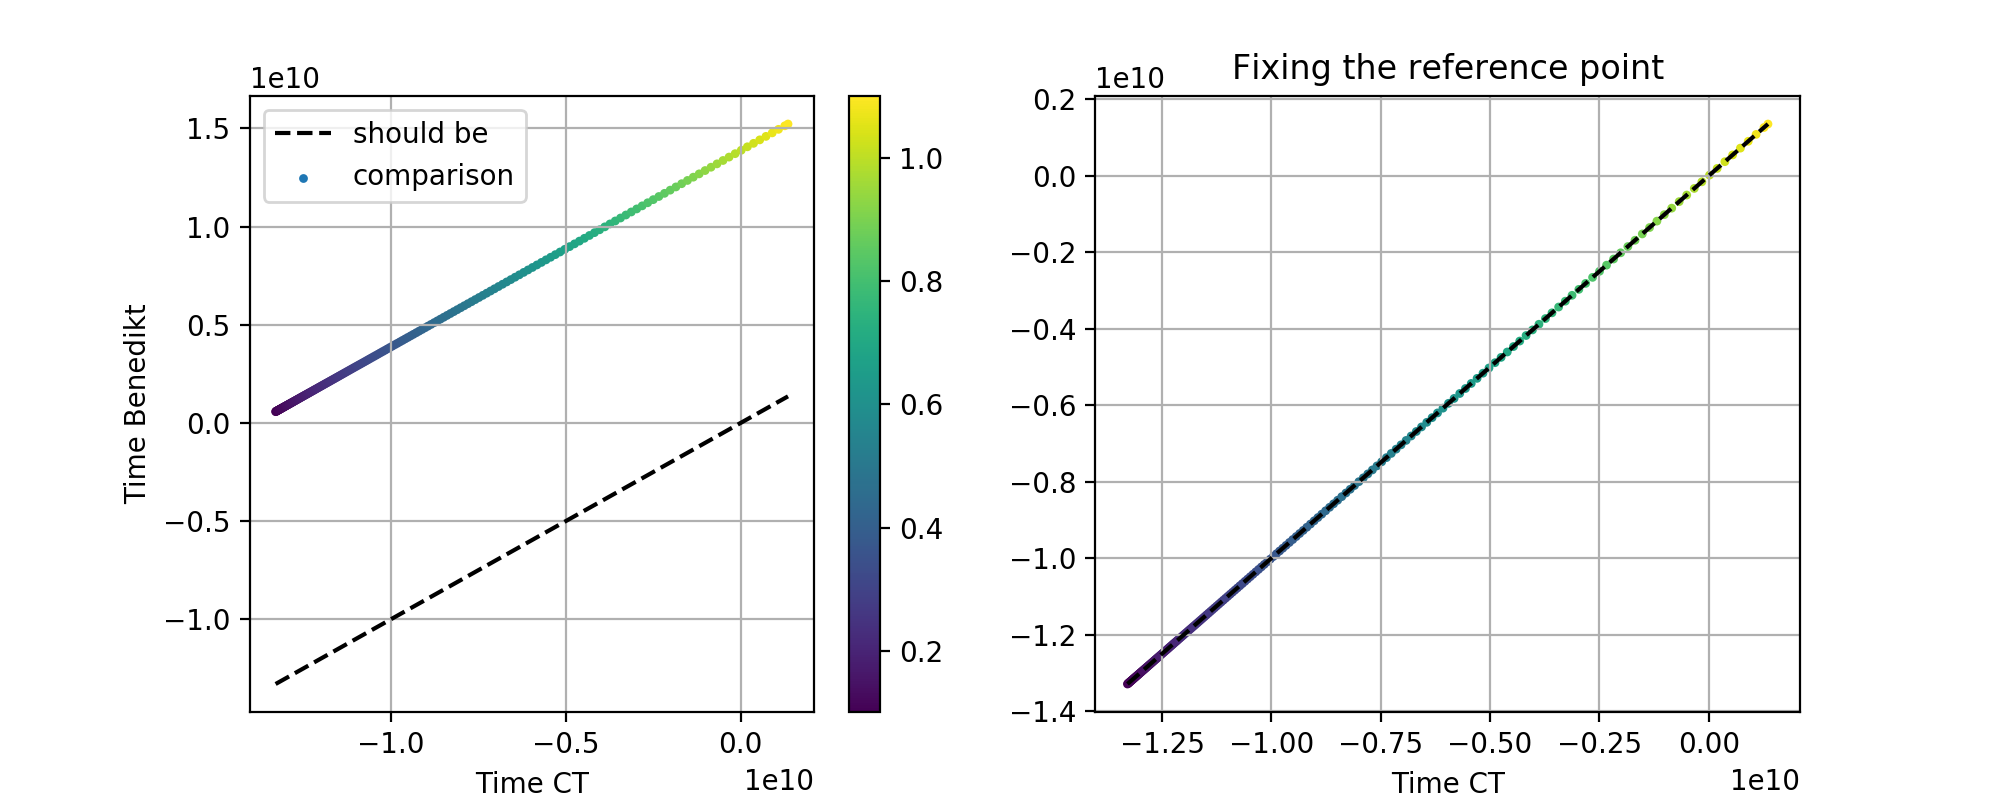

In [72]:
time_b = []
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('bolshoi')

for sf in sf_set: 
    time_b.append(cosmo.age((1-sf)/sf, inverse = False)*1e9)

# print time_ct


plt.figure(figsize = (10,4))
plt.tight_layout()
plt.subplot(121)
plt.grid()
plt.scatter(times_set, time_b, c = sf_set, s= 10, linewidth = 0, alpha = 1., label = "comparison", cmap='viridis')
plt.plot(times_set, times_set, "k--", label = "should be")
plt.xlabel("Time CT")
plt.ylabel("Time Benedikt")
plt.colorbar()
plt.legend()
# plt.savefig("/Users/eniaxhakaj/Desktop/time_comparison_2.pdf")

# So Peter uses a different reference system than Benedikt. Let's look at the slopes of the arrays

# plt.figure()
plt.subplot(122)
plt.grid()
plt.title("Fixing the reference point")
plt.scatter(times_set, time_b+(times_set[0]-time_b[0]), c = sf_set, s= 10, linewidth = 0, alpha = 1., label = "comparison", cmap='viridis')
plt.plot(times_set, times_set, "k--", label = "should be")
plt.xlabel("Time CT")
# plt.ylabel("Time Benedikt")
# plt.colorbar()
# plt.legend()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/scatter_comparing_times_ct_sp.pdf")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/scatter_comparing_times_ct_sp.png")


## How do the scale factors 1tdyn ago CT compare with the ones from Benedikt? 

In [73]:
df_full = pd.read_csv("full_catalog_ct.out")

# do the same thing as for the previous readings. 

sf_now_ct = df_full["sf_now"]
sf_then_ct = df_full["sf_then"]


sf_now_set = np.unique(sf_now_ct)

# print sf_set
# print "what are you doing???"
# print scale_factor_ct[:10]
# list(df_sorted)

# plot scale factor vs time 
sf_then_set = []

for sf in sf_now_set: 

    # where is this sf in the scale factor full array we got from the perl code
    idx_sf = np.where(sf_now_ct == sf)[0]
    
    # which are the times for that array?
    same_sfnow = sf_then_ct[idx_sf]
    
    # Use the median as your represeantitve
    sf_then_set.append(np.median(same_sfnow))
    


<IPython.core.display.Javascript object>


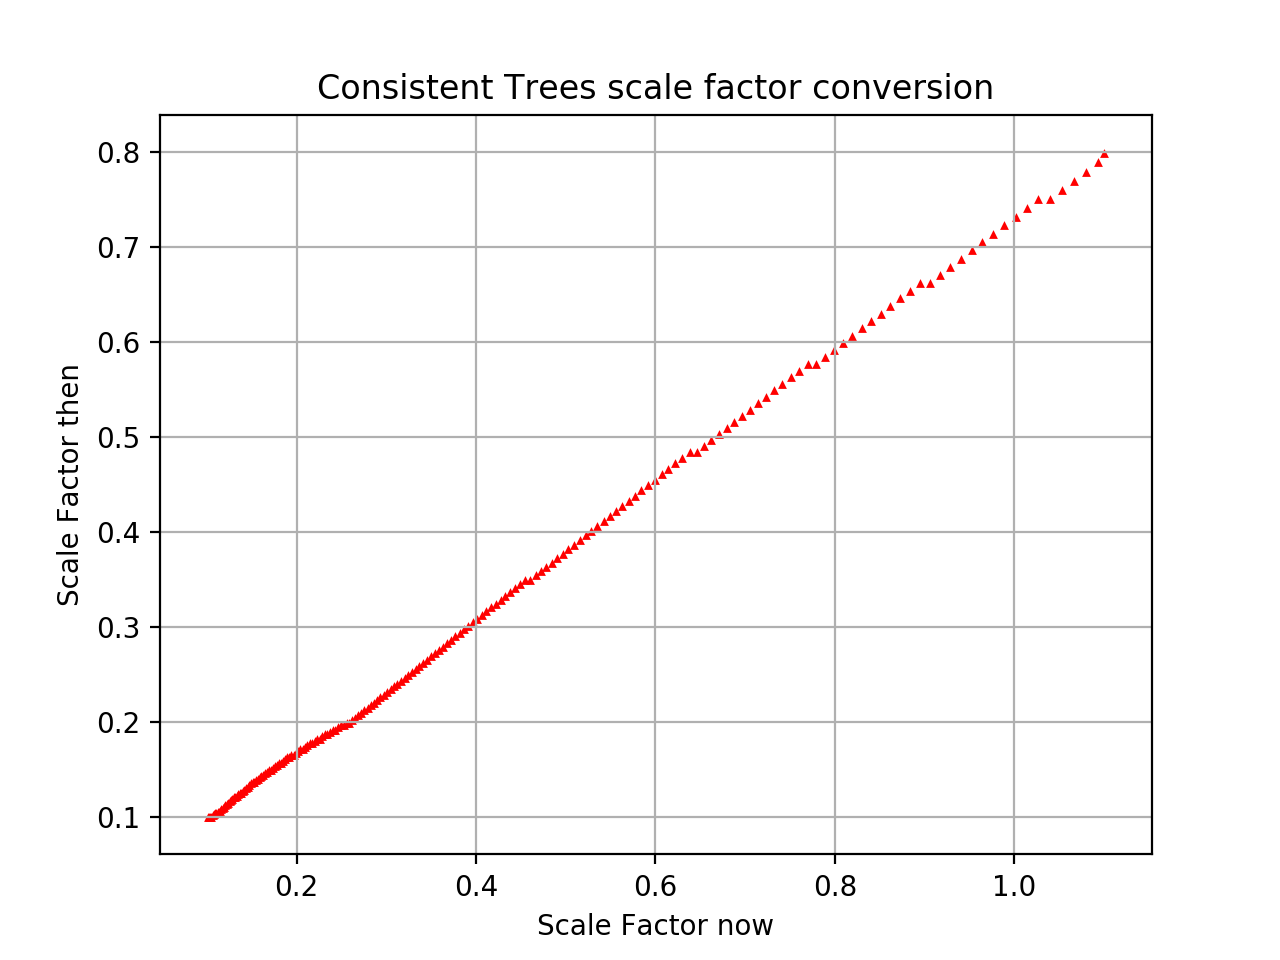

In [74]:
plt.figure()
plt.grid()
plt.scatter(sf_now_set, sf_then_set, marker = "^", s= 10, color = "red", linewidth = 0, alpha = 1.)
plt.xlabel("Scale Factor now")
plt.ylabel("Scale Factor then")
plt.title("Consistent Trees scale factor conversion")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/ct_sf_conversion.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/ct_sf_conversion.pdf")

In [98]:
# NOW COMPARE THIS TO WHAT BENEDIKT HAS 
from colossus.halo.mass_so import dynamicalTime
from colossus.cosmology import cosmology
from colossus.halo import mass_so

cosmo = cosmology.setCosmology('bolshoi')

sfthen_b = []

for sf in sf_now_set:
    
    znow= (1-sf)/sf
    # get the age at the given scale factor
    age_now = cosmo.age(znow, inverse = False)#  +(times_set[0]-time_b[0])/1e9
    
    # get the dynamical time here as well 
    dyntime = dynamicalTime(znow, "vir", definition='crossing') # dynamical time at our redshift 
    
    # get age one dynamical time ago
    age_then = age_now-dyntime
    
    # convert this to scale factor 
    zthen = cosmo.age(age_then, inverse = True)
    
    sfthen_exact = 1/(1.+zthen)
    
    # get the closest scale factor that agrees with the snapshot list 
    idx = np.argmin(abs(sf_now_set-sfthen_exact))
    
    sfthen_b.append(sf_now_set[idx])

<IPython.core.display.Javascript object>


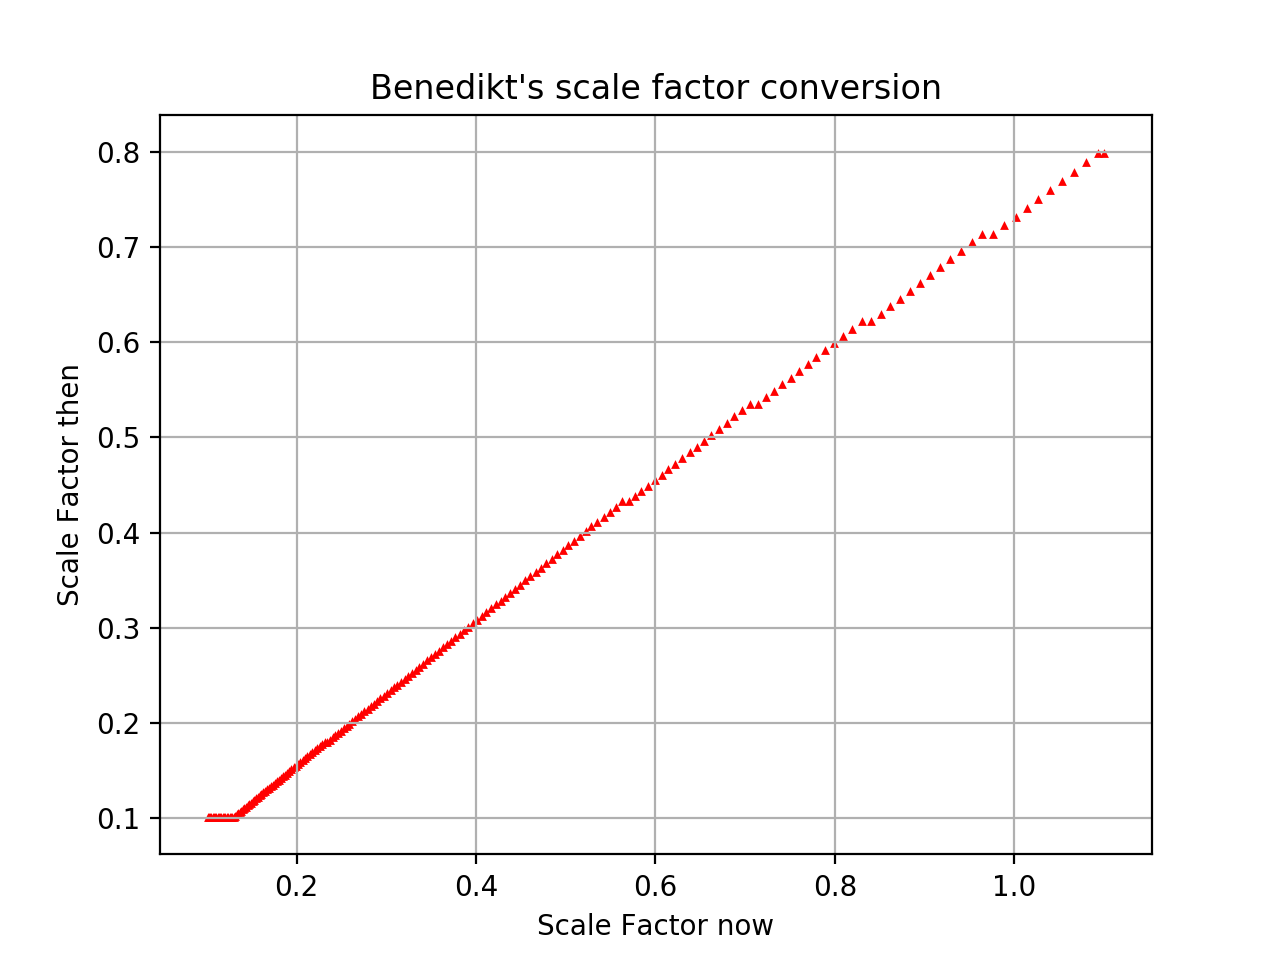

In [99]:
plt.figure()
plt.grid()
plt.scatter(sf_now_set, sfthen_b, marker = "^", s= 10, color = "red", linewidth = 0, alpha = 1.)
plt.xlabel("Scale Factor now")
plt.ylabel("Scale Factor then")
plt.title("Benedikt's scale factor conversion")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/benedikt_sf_conversion_vir.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/benedikt_sf_conversion_vir.pdf")

<IPython.core.display.Javascript object>


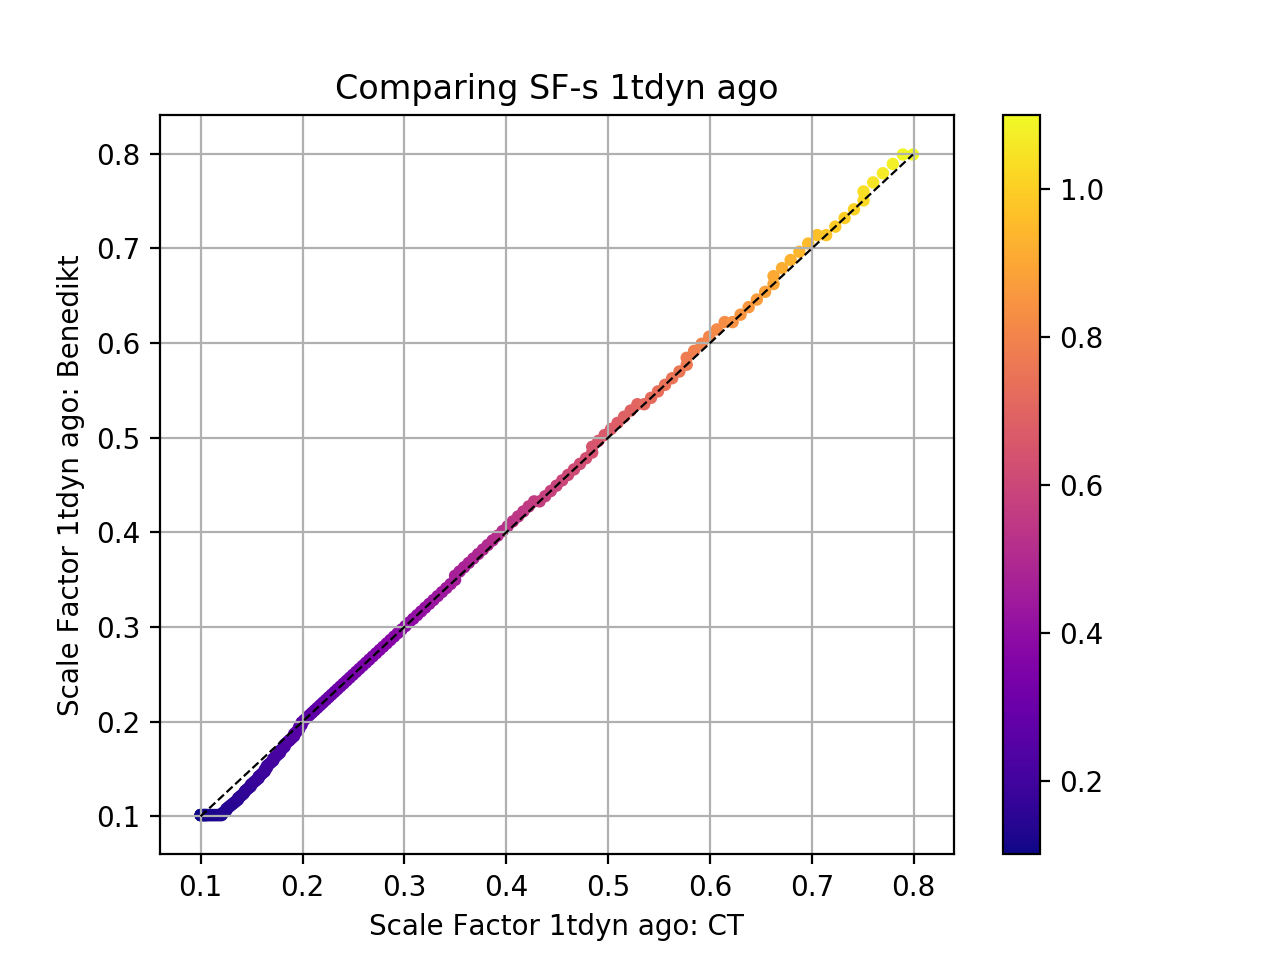

In [100]:
# Now putting everything together 

plt.figure()
plt.grid()
plt.scatter(sf_then_set, sfthen_b, marker = "o", s= 20, c = sf_now_set, linewidth = 0, alpha = 1., cmap='plasma')
plt.plot(sf_then_set, sf_then_set, "k--", linewidth = .8)
plt.xlabel("Scale Factor 1tdyn ago: CT")
plt.ylabel("Scale Factor 1tdyn ago: Benedikt")
plt.title("Comparing SF-s 1tdyn ago")
plt.colorbar()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/sfthen_benedikt_ct_vir.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/sfthen_benedikt_ct_vir.pdf")



## The issue might be in the dynamical time 

In [77]:
# dynamical time with colossus
# dynamical time with CT

dyntime_ct = df_full["tdyn"]

dyntime_ct_set = []
dyntime_colossus = []

for sf in sf_now_set:
    
    znow= (1-sf)/sf
    
    # ----- dynamical time with colossus -----
    dyntime = dynamicalTime(znow, "200m", definition='crossing')*1e9 # dynamical time at our redshift 
    
    dyntime_colossus.append(dyntime)
    
    # ----- dynamical time with CT perl code -----

    # where is this sf in the scale factor full array we got from the perl code
    idx_sf = np.where(sf_now_ct == sf)[0]
    
    # which are the times for that array?
    same_sfnow = dyntime_ct[idx_sf]
    
    # Use the median as your represeantitve
    dyntime_ct_set.append(np.median(same_sfnow))
    

<IPython.core.display.Javascript object>


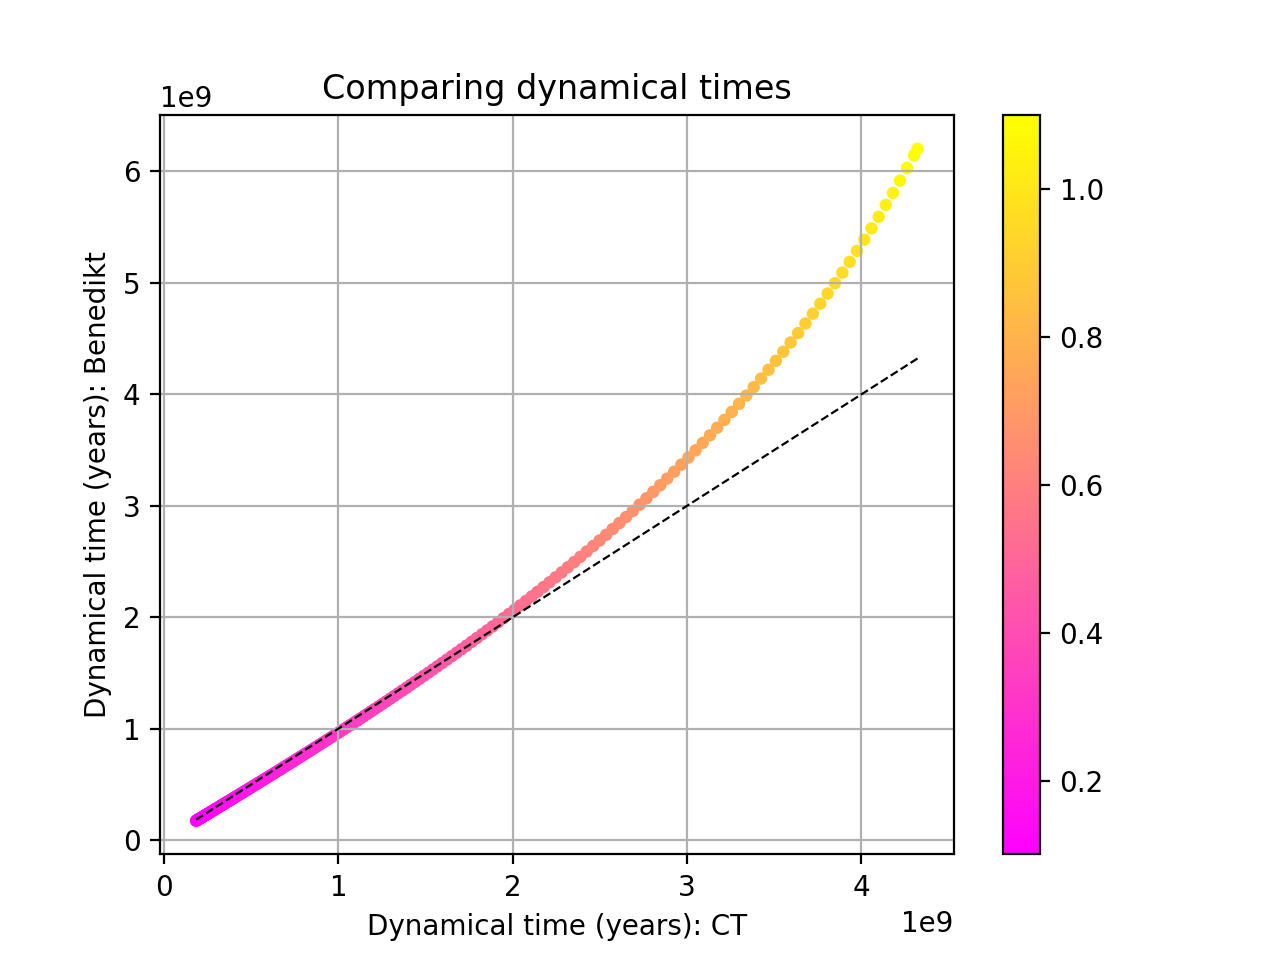

In [78]:
plt.figure()
plt.grid()
plt.scatter(dyntime_ct_set, dyntime_colossus, marker = "o", s= 20, c = sf_now_set, linewidth = 0, alpha = 1., cmap='spring')
plt.plot(dyntime_ct_set, dyntime_ct_set, "k--", linewidth = .8)
plt.xlabel("Dynamical time (years): CT")
plt.ylabel("Dynamical time (years): Benedikt")
plt.title("Comparing dynamical times")
plt.colorbar()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_benedikt_ct.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_benedikt_ct.pdf")



In [79]:
# catalog file produced by SPARTA
catalogname = "/Users/eniaxhakaj/Github/splashbackweaklensing/Gamma_calibration/hlist_1.10000_vpeak.hdf5"
halocat_new = h5py.File(catalogname, "r")

# get the most important values/attributes from the SPARTA catalog 
spnew_dyntime = halocat_new["simulation"].attrs["snap_tdyn"] * 1e9 # get the value for a = 1.1 


<IPython.core.display.Javascript object>


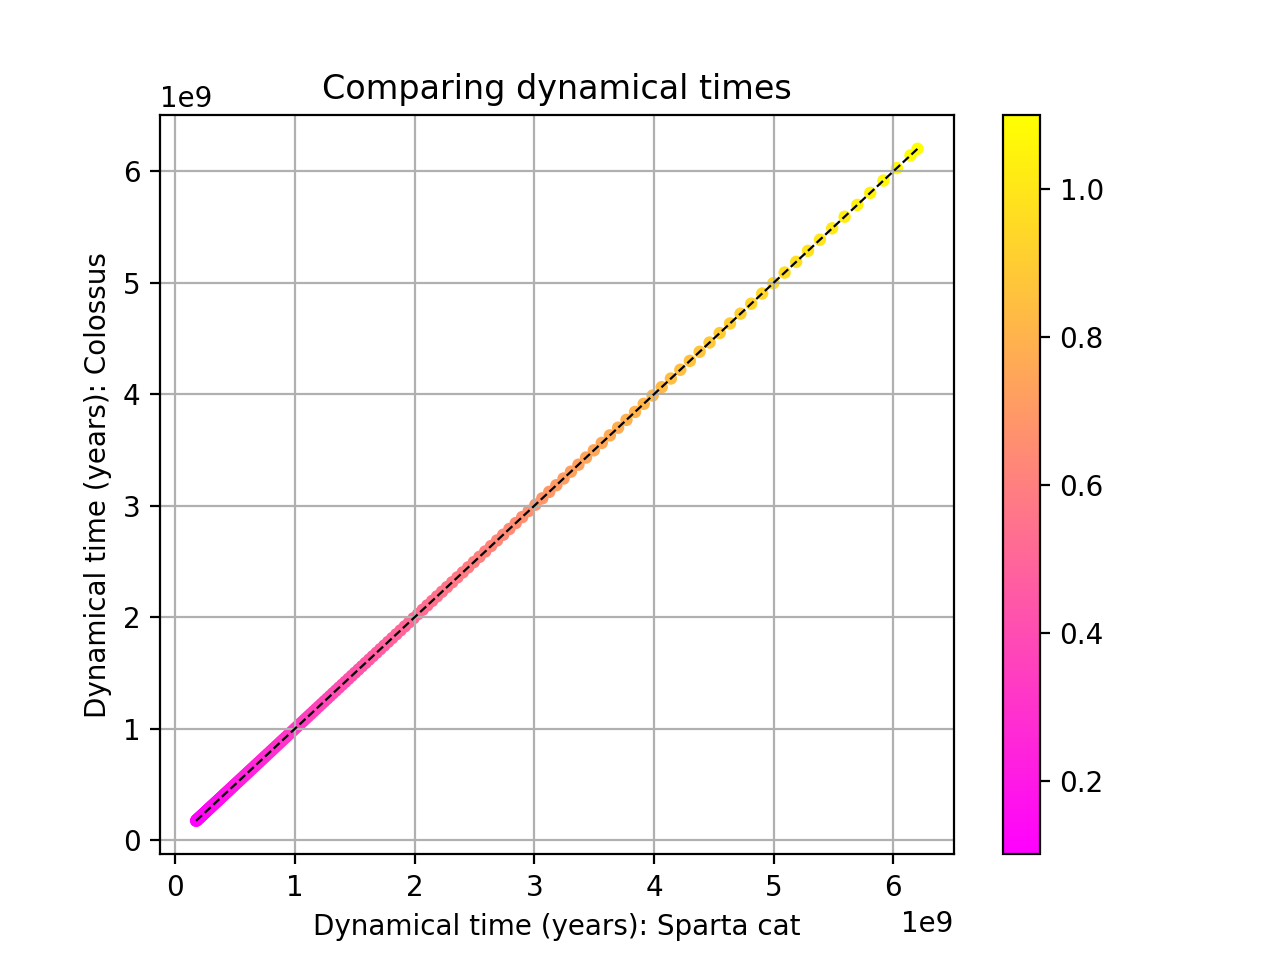

In [80]:
plt.figure()
plt.grid()
plt.scatter(spnew_dyntime[1:], dyntime_colossus, marker = "o", s= 20, c = sf_now_set, linewidth = 0, alpha = 1., cmap='spring')
plt.plot(dyntime_colossus, dyntime_colossus, "k--", linewidth = .8)
plt.xlabel("Dynamical time (years): Sparta cat")
plt.ylabel("Dynamical time (years): Colossus")
plt.title("Comparing dynamical times")
plt.colorbar()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_colossus_sp.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_colossus_sp.pdf")



<IPython.core.display.Javascript object>


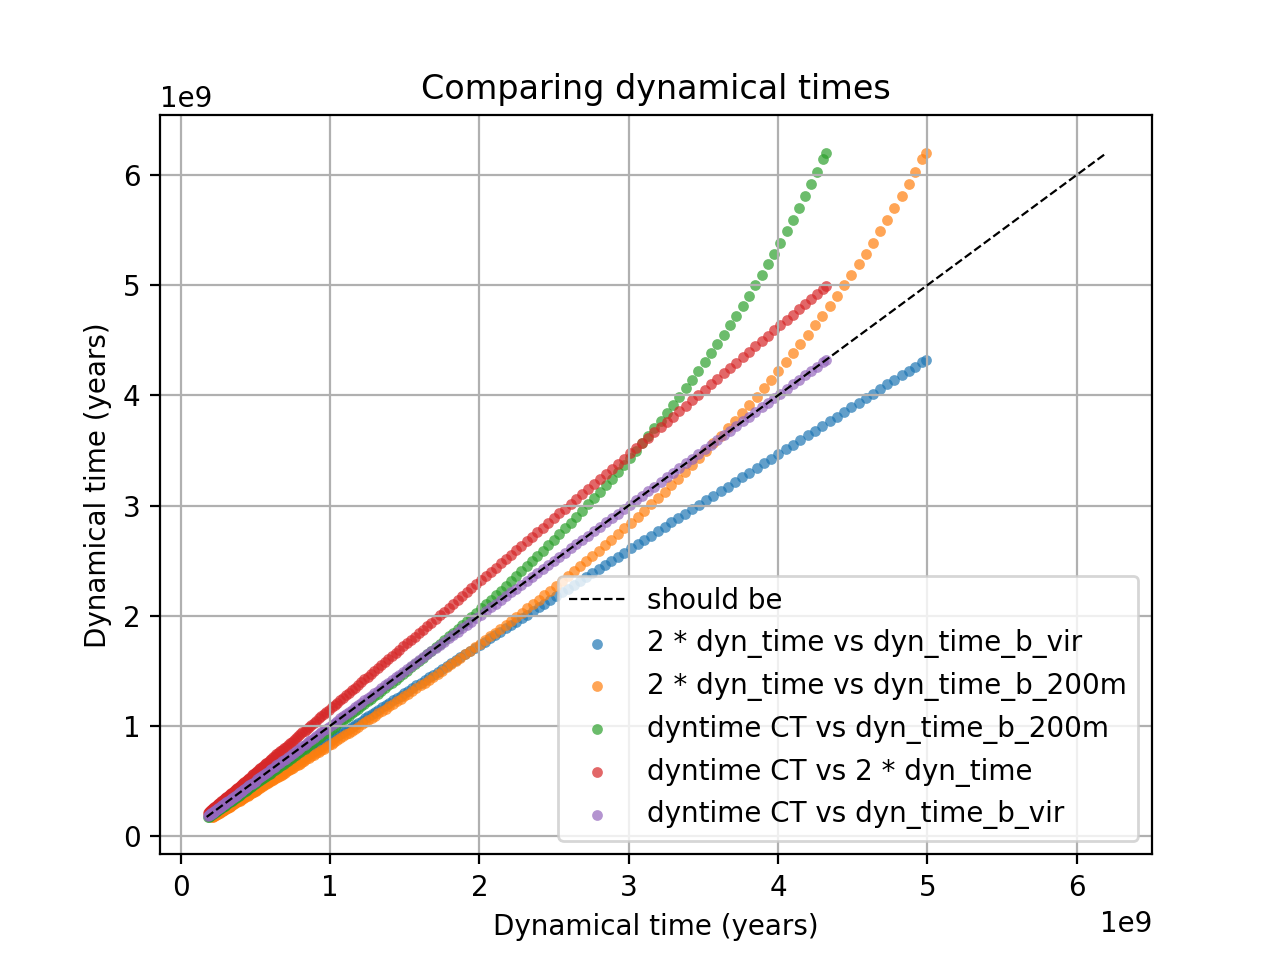

In [97]:
cosmo = cosmology.setCosmology("bolshoi")
z = (1-sf_now_set)/sf_now_set
Delta = mass_so.deltaVir(z) / cosmo.Om(z)
# print(Delta)

g = 4.30117902e-9 #Actually, Gc * (Msun / Mpc) in (km/s)^2
cd = 2.77519737e11 #3H^2/8piG in (Msun / h) / (Mpc / h)^3
bd =  cd * cosmo.Om0 * ((1 + z)**3) #background density
dyn_time = 1.0 / (np.sqrt((4 / 3) * np.pi * g * Delta * bd) * cosmo.h); # in Mpc / (km/s)
dyn_time *= 9.77813106e11 # Mpc/(km/s) to yrs
# dyn_time /= 1e9

dyn_time_me_vir = mass_so.dynamicalTime(z, "vir") * 1e9
dyn_time_me_200m = mass_so.dynamicalTime(z, "200m") * 1e9

# print(dyn_time, dyn_time_me, 2 * dyn_time / dyn_time_me)

plt.figure()
plt.grid()
plt.scatter(2 * dyn_time, dyn_time_me_vir, marker = "o", s= 15, linewidth = 0, alpha = .7, label = "2 * dyn_time vs dyn_time_b_vir")
plt.scatter(2 * dyn_time, dyn_time_me_200m, marker = "o", s= 15, linewidth = 0, alpha = .7, label = "2 * dyn_time vs dyn_time_b_200m")
plt.scatter(dyntime_ct_set, dyn_time_me_200m, marker = "o", s= 15, linewidth = 0, alpha = .7, label = "dyntime CT vs dyn_time_b_200m")
plt.scatter(dyntime_ct_set, 2 * dyn_time, marker = "o", s= 15, linewidth = 0, alpha = .7, label = "dyntime CT vs 2 * dyn_time")
plt.scatter(dyntime_ct_set, dyn_time_me_vir, marker = "o", s= 15, linewidth = 0, alpha = .7, label = "dyntime CT vs dyn_time_b_vir")
plt.plot(dyntime_colossus, dyntime_colossus, "k--", linewidth = .8, label = "should be")
plt.xlabel("Dynamical time (years)")
plt.ylabel("Dynamical time (years)")
plt.title("Comparing dynamical times")
plt.legend()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_benedikt.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/tdyn_benedikt.pdf")


# Using the *right* definition of the dynamical time, repeat the MAR computation here

In [253]:
# -----  FOR THE CONSISTENT TREES CASE --------

halo_now = h5py.File("/Users/eniaxhakaj/data/gamma_tests/hlist_1.10000.hdf5", "r")
id_now_ct = halo_now["data"]["halo_id"]
m200b_all_now = halo_now["data"]["halo_M200b_all"]

halo_then = h5py.File("/Users/eniaxhakaj/data/gamma_tests/hlist_0.79927.hdf5", "r")
m200b_all_then = halo_then["data"]["halo_M200b_all"]


id_then_ct = [] # id of the halo 1 dynamical time ago 
M200b_all_id_then = [] # mass of the halo 1 dynamical time ago \
M200b_all_now = []
keep_idx_now = [] # some of the halos might now have progenitors. Therefore we need to take only the ones that do. 
id_used_ct = []

for iID, ID in enumerate(id_now_ct): 

    # find the ID then of the halo
    idx = np.where(df_full["id_now"] == ID)[0]
    id_then = float(df_full["id_then"][idx])
    
    
    # find the m200b_all of the halo
    idx_then = np.where(halo_then["data"]["halo_id"] == id_then)[0]
    
    if len(idx_then) == 0: 
        continue 
    
    keep_idx_now.append(iID)
    m200b_all_id = m200b_all_then[idx_then]
    M200b_all_now.append(m200b_all_now[iID])
    M200b_all_id_then.append(float(m200b_all_id))
#     id_then_ct.append(id_then)
    
#     id_used_ct.append(ID)
    # so by the end of this for loop we're gonna have all the halos as arranged by id_now_ct


In [254]:
# ---- Now compute the MAR from sparta using their dynamical times  ------ 

from colossus.halo.mass_so import R_to_M
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('bolshoi')

z_now = (1-1.1)/1.1

# OPEN SPARTA DATA 
filename = '/Users/eniaxhakaj/Github/splashbackweaklensing/Gamma_calibration/sparta_test.hdf5'
fsparta = h5py.File(filename, 'r')

# GET ALL R200M AND ID THAT WE NEED TO MEASURE MAR
R200m_sp = fsparta["halos"]["R200m"].value
ID_sp =  fsparta["halos"]["id"].value
a_sparta = fsparta["simulation"].attrs['snap_a']
ID_sparta = fsparta["halos"]["id"].value

# COMPUTE THE SCALE FACTOR 1TDYN AGO USING THE VIR DYNAMICAL TIME 

age_now = cosmo.age(znow, inverse = False)#  +(times_set[0]-time_b[0])/1e9

# get the dynamical time here as well 
dyntime = dynamicalTime(znow, "vir", definition='crossing') # dynamical time at our redshift 

# get age one dynamical time ago
age_then = age_now-dyntime

# convert this to scale factor 
zthen = cosmo.age(age_then, inverse = True)

# scale factor 1 dyntime ago 
a_sparta_then = 1./(1.+zthen)

a_idx_sparta = np.argmin(abs(a_sparta-a_sparta_then))# where is the index of the final scale factor in sparta's SF array

# ---------- GET SPARTA'S MASS NOW & THEN -------------
keep_idx_now_sp =  []
M200m_sp_now = []
M200m_sp_then = []
id_used_sp = []

for iID, ID in enumerate(id_now_ct[keep_idx_now]): 
    
    # find the index of the halo we're tracking down 
    halo_idx_now_sp = zip(*np.where(ID_sp == int(ID)))

    # keep only the indecces of the halos that we know that are part of SPARTA as well 
    if len(halo_idx_now_sp) == 0: 
        continue
        
    halo_idx_now_sp = halo_idx_now_sp[0]
    
    
    # get the mass and radius of the halo
    r200m_now_sp = R200m_sp[halo_idx_now_sp[0], halo_idx_now_sp[1]]
    m200m_now_sp = R_to_M(r200m_now_sp, z_now, "200m")
        
#     # Given the scale factor 1 dyntime ago, find the ID of the halo at that point 
    sparta_idx_then = (halo_idx_now_sp[0], a_idx_sparta)
    ID_sparta_then = ID_sparta[sparta_idx_then[0], sparta_idx_then[1]]
    
    r200m_then_sp = R200m_sp[sparta_idx_then[0], sparta_idx_then[1]]
    m200m_then_sp = R_to_M(r200m_then_sp, zthen, "200m")

    if m200m_now_sp/m200m_then_sp < 0:
        continue 
        
    keep_idx_now_sp.append(iID)  
    M200m_sp_now.append(m200m_now_sp)
    M200m_sp_then.append(m200m_then_sp)
#     id_used_sp.append(ID)

<IPython.core.display.Javascript object>


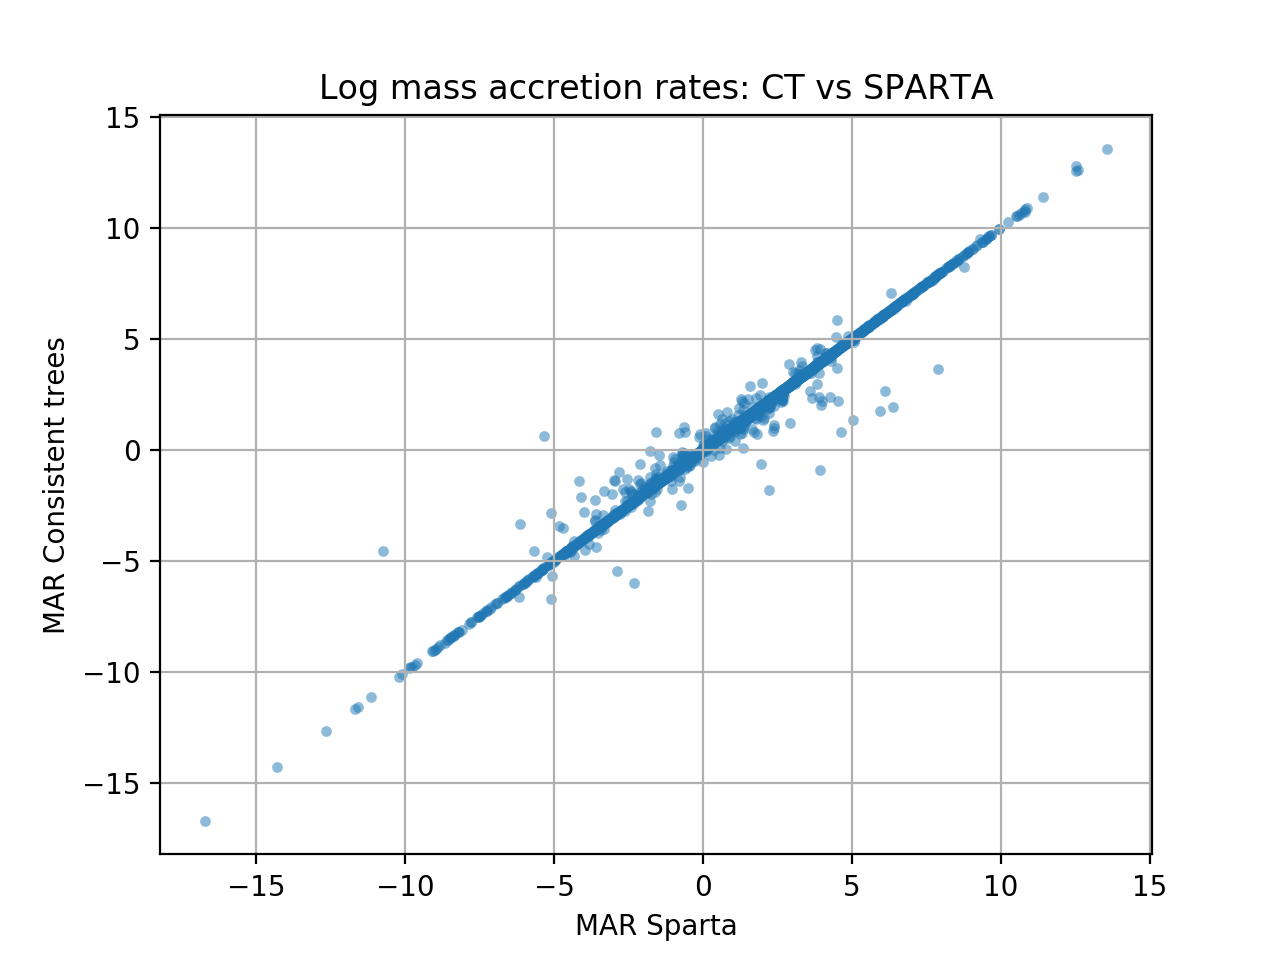

In [260]:

M200b_all_nowc = np.array(M200b_all_now)[keep_idx_now_sp]
M200b_all_id_thenc = np.array(M200b_all_id_then)[keep_idx_now_sp]
M200m_sp_now = np.array(M200m_sp_now)
M200m_sp_then = np.array(M200m_sp_then)

MAR_sp = np.log10(M200m_sp_now/M200m_sp_then)/np.log10(1.10000/a_sparta[a_idx_sparta])
MAR_ct = np.log10(M200b_all_nowc/M200b_all_id_thenc)/np.log10(1.1/0.79927)

plt.figure()
plt.title("Log mass accretion rates: CT vs SPARTA")
# plt.hist(MAR_sp[idx_to_keep_sp], bins = 100);
# plt.hist(MAR_ct[idx_to_keep_ct], bins = 100, alpha = .3)
# plt.scatter()
plt.scatter(MAR_sp, MAR_ct , marker = "o", s= 15, linewidth = 0, alpha = .5) #, label = "dyntime CT vs dyn_time_b_vir")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("MAR Sparta")
plt.ylabel("MAR Consistent trees")
plt.grid()
plt.savefig("/Users/eniaxhakaj/Desktop/last_result.png")


In [261]:
# ---- FROM THE NEW CATALOG OF SPARTA ------ 

catalogname = "/Users/eniaxhakaj/Github/splashbackweaklensing/Gamma_calibration/hlist_1.10000_vpeak.hdf5"
halocat_new = h5py.File(catalogname, "r")

# get the most important values/attributes from the SPARTA catalog 
spnew_m200b_all = halocat_new["halos"]["M200m_all"].value
Spnew_id = halocat_new["halos"]["id"].value
Spnew_gamma = halocat_new["halos"]["Gamma"].value 
# spnew_dyntime = halocat_new["simulation"].attrs["snap_tdyn"][-1] # get the value for a = 1.1 
gamma_spnew = []
keep_spnew = []
for iID, ID in enumerate(id_now_ct[keep_idx_now]): 

    # find the ID then of the halo
    idx = np.where(Spnew_id == ID)[0]
    
    
    if len(idx) == 0: 
        continue 
    
    gamma_spnew.append(Spnew_gamma[idx])
    keep_spnew.append(idx)  

<IPython.core.display.Javascript object>


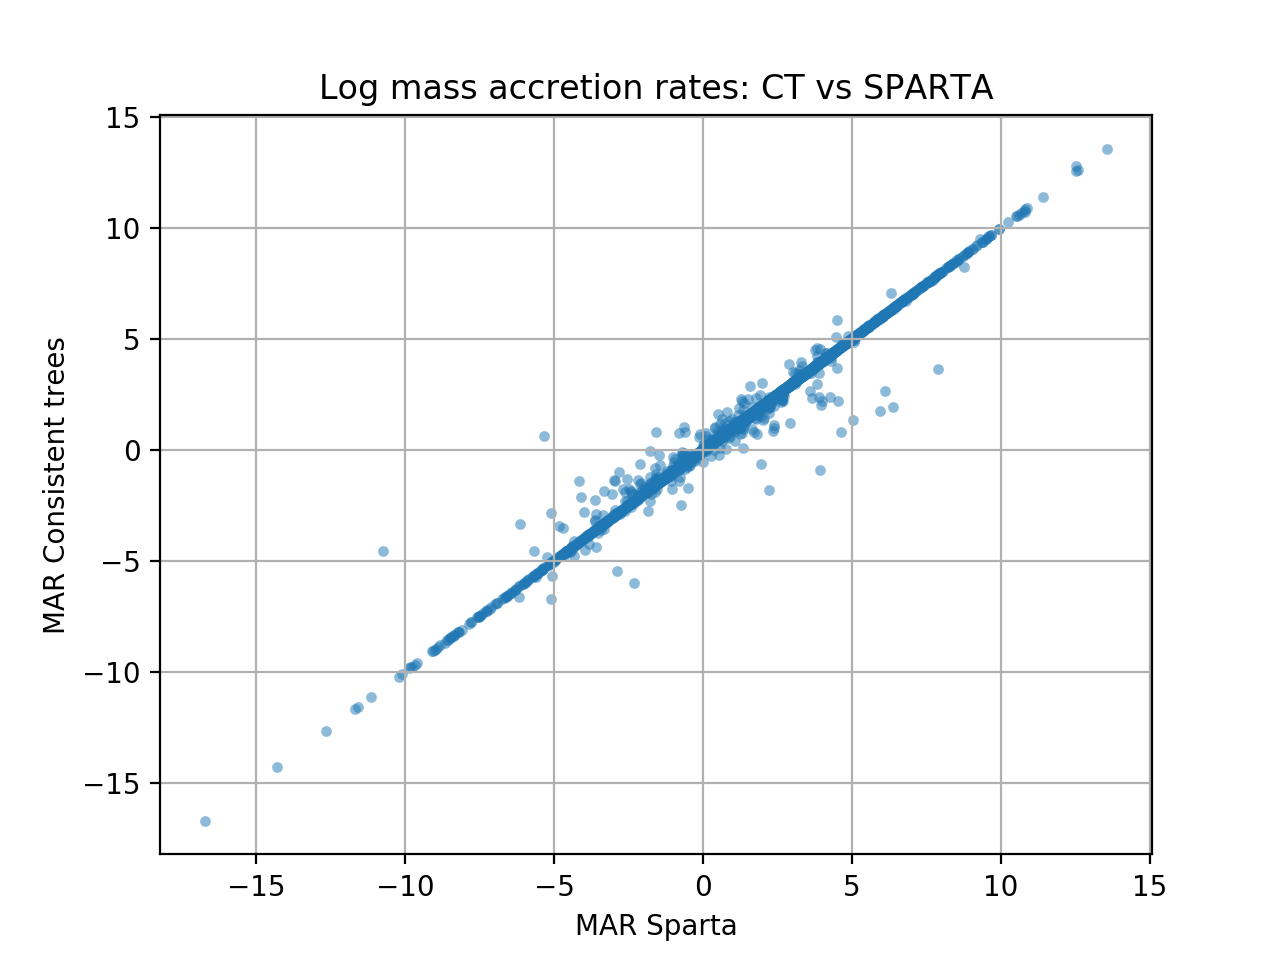

In [264]:

M200b_all_nowc = np.array(M200b_all_now)[keep_idx_now_sp]
M200b_all_id_thenc = np.array(M200b_all_id_then)[keep_idx_now_sp]
M200m_sp_now = np.array(M200m_sp_now)
M200m_sp_then = np.array(M200m_sp_then)

MAR_sp = np.log10(M200m_sp_now/M200m_sp_then)/np.log10(1.10000/a_sparta[a_idx_sparta])
MAR_ct = np.log10(M200b_all_nowc/M200b_all_id_thenc)/np.log10(1.1/0.79927)

plt.figure()
plt.title("Log mass accretion rates: CT vs SPARTA")
# plt.hist(MAR_sp[idx_to_keep_sp], bins = 100);
# plt.hist(MAR_ct[idx_to_keep_ct], bins = 100, alpha = .3)
# plt.scatter()
plt.scatter(MAR_sp, MAR_ct , marker = "o", s= 15, linewidth = 0, alpha = .5) #, label = "dyntime CT vs dyn_time_b_vir")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("MAR Sparta")
plt.ylabel("MAR Consistent trees")
plt.grid()
plt.savefig("/Users/eniaxhakaj/Desktop/last_result.png")
